## Assessment / Midterm: Machine Vision and Deep Learning



    
### Name    : Yaman H.S. Aburaneh
### Matric  : 1720907
### Section : 2
    

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is (1, 12, 5, 5).
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer) (2 marks)

 - [X] Individual feature map
 - [ ] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is not an advantage of Batch Normalization (BN)? (tick X for the correct answer) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [x] BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [x] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [9]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 122 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [X] Deep neural networks usually require a big amount of data to be properly trained.
- [X] They can be fooled by adversarial/ noisy examples.
- [X] They are difficult to interpret and understand.
- [X] They can still be subject to biases.
- [X] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell. 

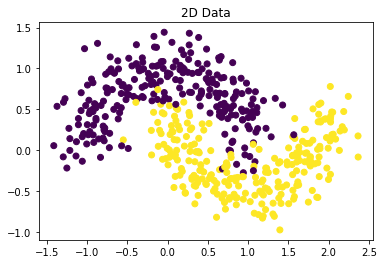

In [1]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    Answer: The data provided cannot be classified using a linear classifier because the boundary between the classes is non-linear. In this case, a single-layer neural network with a linear layer and a sigmoid activation function will not work. Instead, a non-linear classifier must be used to accurately classify the data.
</span>

**QUESTION 2 [50 marks]** 

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is effective screening of infected patients, with one of the key screening approaches being radiology examination using chest radiography. As a deep learning engineer, you are tasked to classify a dataset of X-ray images as either "normal", "covid" or "viral pneumonia". Use the chest X-ray dataset publicly available at https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset to answer the following questions.


a) Train a feedforward neural network to solve the classification problem. Please include: **(10 marks)**

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) The training loop.

    4) Output the mean accuracy for the whole testing dataset.
    
    5) The hyperparameters are:
        i  - architecture: 2 hidden layers
        ii - input size  : 32x32 

In [39]:
# Import Libraries
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [3]:
# Data Loader
# Define the transform to apply to the dataset
transform = transforms.Compose([
    transforms.Resize((32,32)),  # resize the images to 32x32 pixels
    transforms.ToTensor(),  # convert the images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize the images
])

batch_size = 32

# Load the train and test datasets
train_dataset = datasets.ImageFolder(root="Covid19-dataset/train", transform=transform)
test_dataset = datasets.ImageFolder(root="Covid19-dataset/test", transform=transform)

# Define the dataloaders to load the data in batches
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Datasets Size
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)
print(train_data_size)
print(test_data_size)

251
66


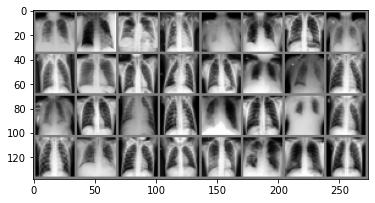

Normal Normal Normal Viral Pneumonia Normal Normal Covid Normal Viral Pneumonia Normal Covid Viral Pneumonia Covid Normal Normal Viral Pneumonia Normal Covid Normal Viral Pneumonia Normal Covid Normal Viral Pneumonia Viral Pneumonia Normal Covid Covid Covid Normal Normal Covid


In [4]:
# function to show the images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
# Define the Feed Forward Model
class myModel(nn.Module): 
    def __init__(self): 
        super(myModel, self).__init__() 
        self.linear1 = nn.Linear(3072, 512) # Input Layer
        self.linear2 = nn.Linear(512, 256)  # First Hidden Layer
        self.linear3 = nn.Linear(256, 128)  # Second Hidden Layer
        self.linear4 = nn.Linear(128, 3)    # Output Layer
        self.relu = nn.ReLU()               # Activation function
  
    def forward(self, x): 
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        o = self.linear4(x)
        return o 
    
model = myModel()

In [6]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

myModel(
  (linear1): Linear(in_features=3072, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [7]:
# Calculate training time
def train_and_validate(model, loss_criterion, optimizer, epochs=30):

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                #reshape images so they can be fed to a nn.Linear()
                inputs = inputs.view(inputs.size(0), -1)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
            
    return model, history

In [8]:
# Train the model for 30 epochs
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/50
Epoch : 000, Training: Loss: 1.1117, Accuracy: 27.8884%, 
		Validation : Loss : 1.1046, Accuracy: 30.3030%, Time: 17.4320s
Epoch: 2/50
Epoch : 001, Training: Loss: 1.1032, Accuracy: 27.8884%, 
		Validation : Loss : 1.0974, Accuracy: 30.3030%, Time: 13.7380s
Epoch: 3/50
Epoch : 002, Training: Loss: 1.0922, Accuracy: 27.8884%, 
		Validation : Loss : 1.0891, Accuracy: 30.3030%, Time: 14.1110s
Epoch: 4/50
Epoch : 003, Training: Loss: 1.0796, Accuracy: 27.8884%, 
		Validation : Loss : 1.0810, Accuracy: 30.3030%, Time: 13.7650s
Epoch: 5/50
Epoch : 004, Training: Loss: 1.0681, Accuracy: 31.4741%, 
		Validation : Loss : 1.0722, Accuracy: 37.8788%, Time: 13.1450s
Epoch: 6/50
Epoch : 005, Training: Loss: 1.0547, Accuracy: 52.1912%, 
		Validation : Loss : 1.0626, Accuracy: 57.5758%, Time: 13.1570s
Epoch: 7/50
Epoch : 006, Training: Loss: 1.0402, Accuracy: 74.5020%, 
		Validation : Loss : 1.0522, Accuracy: 72.7273%, Time: 12.7110s
Epoch: 8/50
Epoch : 007, Training: Loss: 1.0243, Accura

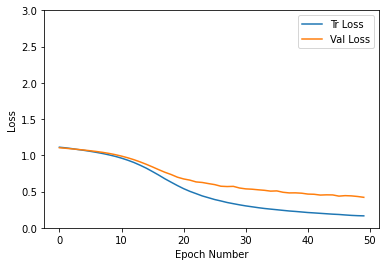

In [9]:
# Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

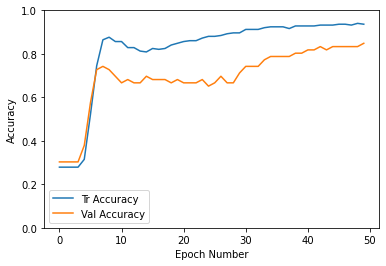

In [10]:
# Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [13]:
# Flatten the images
images = images.to(device)
images = images.view(images.size(0), -1)
outputs = model(images)

# Prediction
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Normal Normal Normal Normal Normal Normal Normal Normal Normal Covid Normal Normal Normal Covid Normal Normal Normal Normal Normal Normal Normal Normal Normal Normal Normal Covid Covid Covid Covid Covid Covid Covid


In [14]:
# Network Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 84 %


In [15]:
# Classes Accuracy

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Normal is 88.5 %
Accuracy for class: Covid is 85.0 %
Accuracy for class: Viral Pneumonia is 80.0 %


<AxesSubplot:>

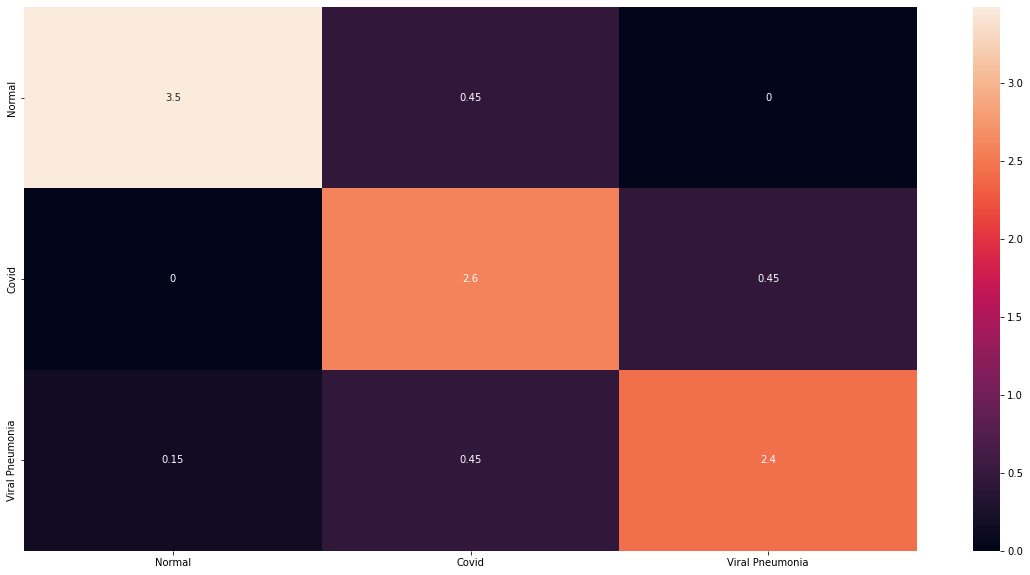

In [16]:
# Confusion Matrix

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in test_dataloader:
        #reshape images so they can be fed to a nn.Linear()
        inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

b) Create and train a ConvNet corresponding to the following architecture in Fig. 1 (with modifications of the input and final layers). Please include **(10 marks)**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 1: A convolutional neural network

In [82]:
# CNN Data Loader
# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.Resize((32,32)),                 # resize the images to 32x32 pixels
    transforms.ToTensor(),                      # convert the images to tensors
    transforms.Normalize((0.5), (0.5)),         # normalize the images
    transforms.Grayscale(num_output_channels=1) #Transform 3 channels to 1 channel
])

batch_size = 32 #Batch Size

# Load the train and test datasets
train_dataset = datasets.ImageFolder(root="Covid19-dataset/train", transform=transform)
test_dataset = datasets.ImageFolder(root="Covid19-dataset/test", transform=transform)

# Define the dataloaders to load the data in batches
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Define Classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Datasets Size
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)
print(train_data_size)
print(test_data_size)

251
66


In [83]:
# Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)  # First Convolution Layer
        self.pool1 = nn.MaxPool2d(2, stride=2)     # First MaxPooling Layer
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1) # Second Convolution Layer
        self.pool2 = nn.MaxPool2d(2, stride=2)     # Second MaxPooling Layer
        self.fc1 = nn.Linear(16*5*5, 120)          # First Fully Connected Layer
        self.fc2 = nn.Linear(120, 10)              # Second Fully Connected Layer
        self.fc3 = nn.Linear(10, 3)                # Output Layer
        self.relu = nn.ReLU()                      # Activation Function

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))               
        x = self.fc2(x)                           
        x = self.fc3(x)                           # Classification Layer
        return x

In [84]:
# CNN Model
model = CNN()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [85]:
# Calculate training time
def train_and_validate(model, loss_criterion, optimizer, epochs=25):

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
            
    return model, history

In [86]:
# Train the model for 25 epochs
num_epochs = 25
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 1.1197, Accuracy: 27.8884%, 
		Validation : Loss : 1.1063, Accuracy: 30.3030%, Time: 14.0820s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.1064, Accuracy: 27.8884%, 
		Validation : Loss : 1.0957, Accuracy: 30.3030%, Time: 13.3280s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.0896, Accuracy: 35.0598%, 
		Validation : Loss : 1.0863, Accuracy: 60.6061%, Time: 14.5260s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.0744, Accuracy: 45.8167%, 
		Validation : Loss : 1.0785, Accuracy: 39.3939%, Time: 16.3685s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.0612, Accuracy: 44.2231%, 
		Validation : Loss : 1.0710, Accuracy: 39.3939%, Time: 13.4480s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.0477, Accuracy: 44.2231%, 
		Validation : Loss : 1.0608, Accuracy: 39.3939%, Time: 13.1060s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.0297, Accuracy: 44.2231%, 
		Validation : Loss : 1.0438, Accuracy: 39.3939%, Time: 15.9089s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.0035, Accura

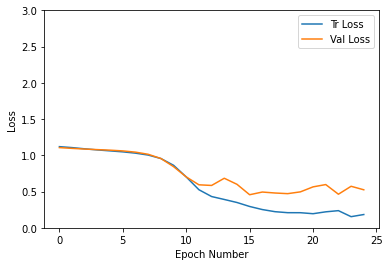

In [87]:
# Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

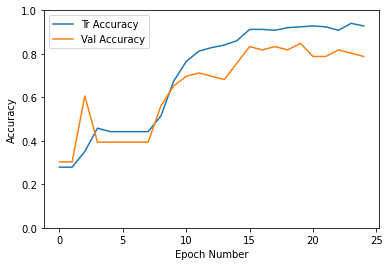

In [88]:
# Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [89]:
# Network Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 78 %


In [90]:
# Classes Accuracy

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Normal is 88.5 %
Accuracy for class: Covid is 55.0 %
Accuracy for class: Viral Pneumonia is 90.0 %


<AxesSubplot:>

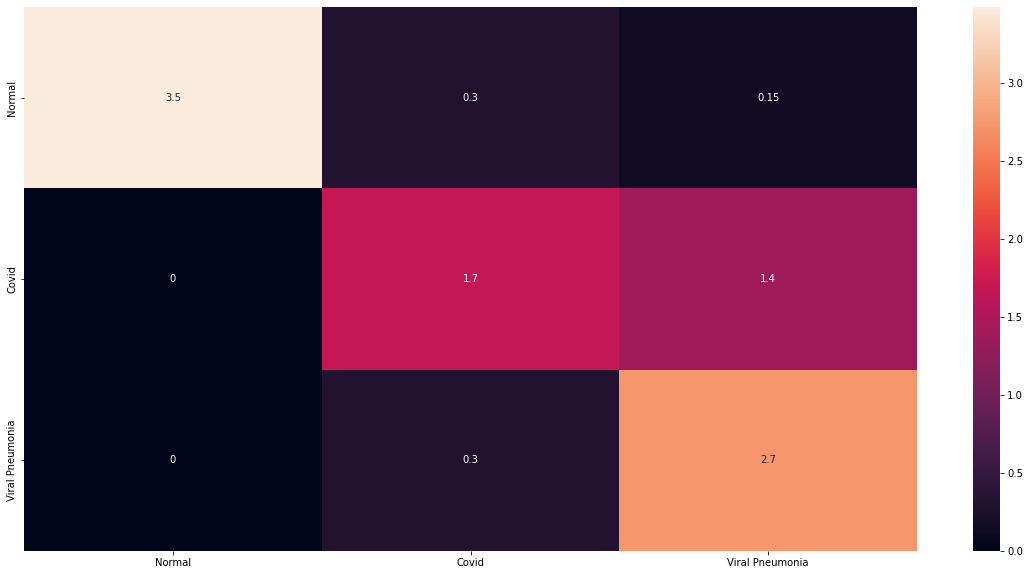

In [91]:
# Confusion Matrix

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

c) Based on Question 2 b), answer the following questions: 
    
    i) Is the model overfitting? Why? (4 marks)
   <font color='blue'>Yes, the model is experiencing overfitting because it has been trained too well on the training data and does not perform as well on new or unseen data. This can happen when the model is trained on too few examples, allowing it to learn the details and noise in the training data to the point where it is unable to generalize to new data. Overfitting can lead to poor performance on new data, so it is best to carefully balance the amount of training and the complexity of the model to avoid this issue.</font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) Batch Normalization (BN) (2) Dropouts</font>
   
    iii) Implement the two proposed methods in Q2 c) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [45]:
# Define the new CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 10)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(10, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)             
        x = self.dropout2(x)
        x = self.fc3(x)          
        return x

In [46]:
# CNN Model
model = CNN()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [47]:
# Train the model for 25 epochs
num_epochs = 25
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 2.0825, Accuracy: 31.0757%, 
		Validation : Loss : 2.1680, Accuracy: 39.3939%, Time: 13.9944s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.2266, Accuracy: 60.9562%, 
		Validation : Loss : 1.6751, Accuracy: 39.3939%, Time: 12.8750s
Epoch: 3/25
Epoch : 002, Training: Loss: 0.9192, Accuracy: 69.7211%, 
		Validation : Loss : 1.6092, Accuracy: 39.3939%, Time: 13.1545s
Epoch: 4/25
Epoch : 003, Training: Loss: 0.8297, Accuracy: 72.1116%, 
		Validation : Loss : 1.1088, Accuracy: 53.0303%, Time: 13.6163s
Epoch: 5/25
Epoch : 004, Training: Loss: 0.6952, Accuracy: 74.9004%, 
		Validation : Loss : 0.6450, Accuracy: 72.7273%, Time: 13.8653s
Epoch: 6/25
Epoch : 005, Training: Loss: 0.5682, Accuracy: 83.2669%, 
		Validation : Loss : 0.5081, Accuracy: 75.7576%, Time: 12.8480s
Epoch: 7/25
Epoch : 006, Training: Loss: 0.5198, Accuracy: 86.0558%, 
		Validation : Loss : 0.3853, Accuracy: 84.8485%, Time: 12.9760s
Epoch: 8/25
Epoch : 007, Training: Loss: 0.4795, Accura

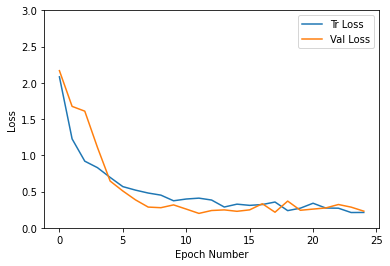

In [48]:
# Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

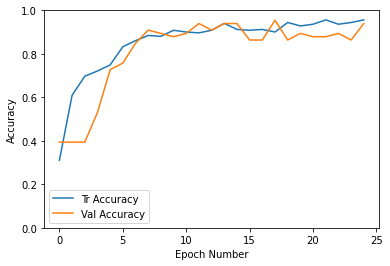

In [49]:
# Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [50]:
# Network Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 93 %


In [51]:
# Classes Accuracy

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Normal is 96.2 %
Accuracy for class: Covid is 100.0 %
Accuracy for class: Viral Pneumonia is 85.0 %


<AxesSubplot:>

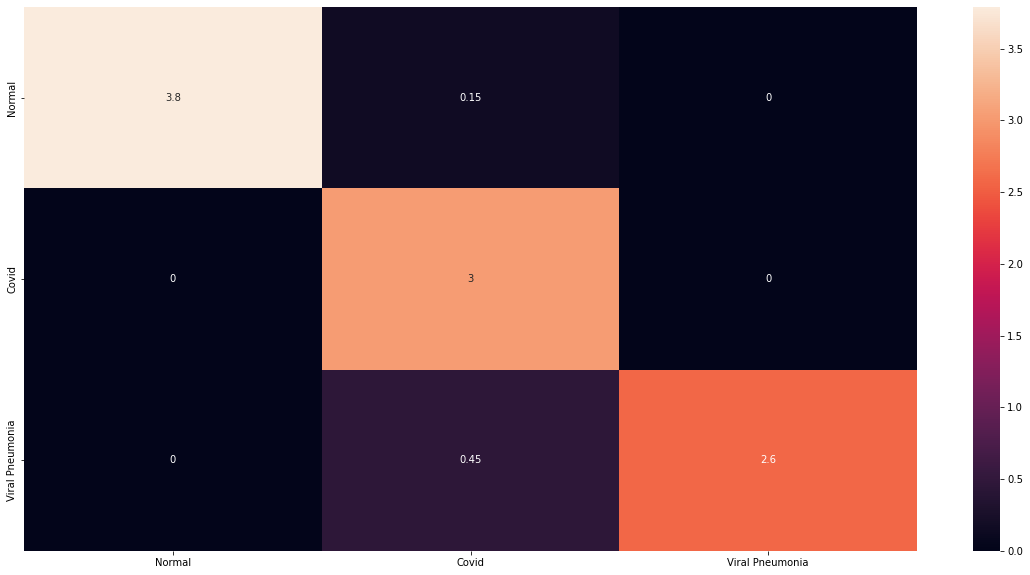

In [52]:
# Confusion Matrix

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

d) Replace your defined ConvNet in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the COVID-19 dataset. **(10 marks)**

In [74]:
#ResNet50 Pre-Trained Object Classification Model
resnet50 = models.resnet50(pretrained=True)
print(resnet50)
model = resnet50

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

# Move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [75]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
            
    return model, history

In [76]:
# Train the model for 25 epochs
num_epochs = 25
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 3.2353, Accuracy: 58.9641%, 
		Validation : Loss : 0.2712, Accuracy: 90.9091%, Time: 19.1830s
Epoch: 2/25
Epoch : 001, Training: Loss: 0.2200, Accuracy: 94.0239%, 
		Validation : Loss : 0.9208, Accuracy: 68.1818%, Time: 19.5150s
Epoch: 3/25
Epoch : 002, Training: Loss: 0.1719, Accuracy: 96.4143%, 
		Validation : Loss : 0.5084, Accuracy: 78.7879%, Time: 19.5260s
Epoch: 4/25
Epoch : 003, Training: Loss: 0.3062, Accuracy: 92.8287%, 
		Validation : Loss : 2.8688, Accuracy: 74.2424%, Time: 26.7681s
Epoch: 5/25
Epoch : 004, Training: Loss: 0.1934, Accuracy: 95.6175%, 
		Validation : Loss : 0.9386, Accuracy: 83.3333%, Time: 28.0066s
Epoch: 6/25
Epoch : 005, Training: Loss: 0.1998, Accuracy: 94.4223%, 
		Validation : Loss : 0.3606, Accuracy: 87.8788%, Time: 27.1497s
Epoch: 7/25
Epoch : 006, Training: Loss: 0.0969, Accuracy: 95.6175%, 
		Validation : Loss : 0.2146, Accuracy: 95.4545%, Time: 30.7121s
Epoch: 8/25
Epoch : 007, Training: Loss: 0.0492, Accura

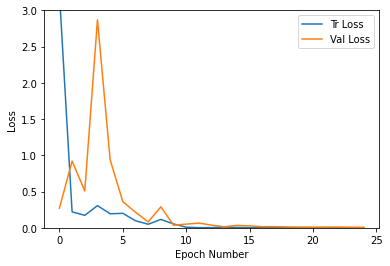

In [77]:
# Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

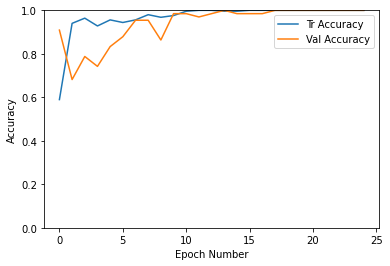

In [78]:
# Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [79]:
# Network Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 100 %


In [80]:
# Classes Accuracy

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Normal is 100.0 %
Accuracy for class: Covid is 100.0 %
Accuracy for class: Viral Pneumonia is 100.0 %


<AxesSubplot:>

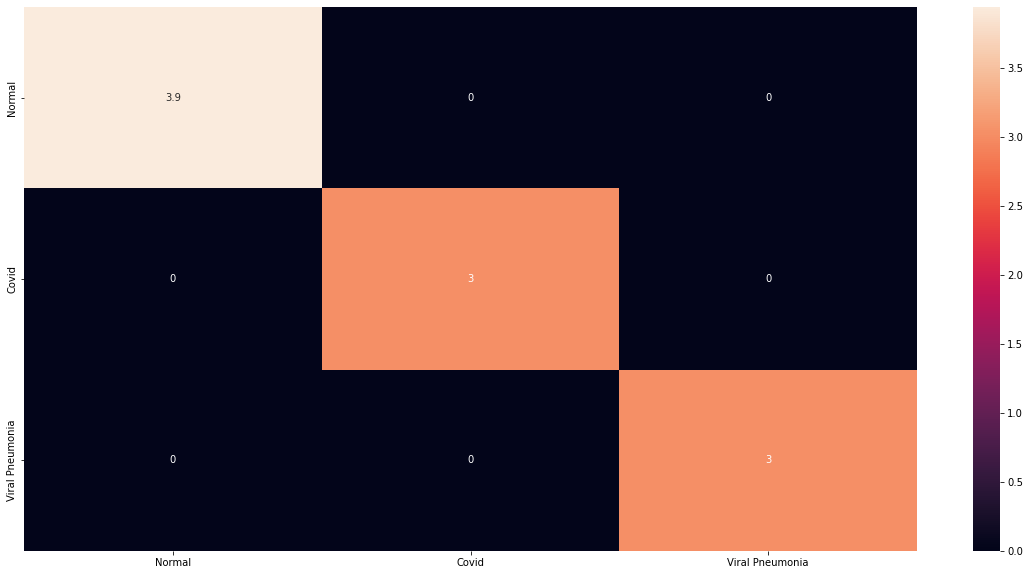

In [81]:
# Confusion Matrix

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

e) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **(4 marks)**

<span style="color:blue">
    The overall accuracy of detection has improved compared to previous convolutional neural networks (CNNs). This is because the pretrained model's parameters have been fine-tuned to fit the specific classification requirements and it has more hidden layers. This results in improved accuracy and resulted in much faster training duration. </span>

**QUESTION 3** **[15 marks]**

In a machine vision project, you decide to design a door access control system based on hand gestures. Only those who shows the correct hand gesture will be granted the access. There are three gestures that are recognized as correct access passcode which are "shaka", "peace" and "thumbs up", as depicted in Fig. 2.

![pic](https://simplyorganizedhi.com/media/catalog/product/1/6/169500.jpg)

                                Fig. 2 Shaka,peace, and thumbs up


Using the end-to-end object detection pipeline that you have learned, develop your own hand gesture detector so that it can be incorporate to a door access control system.

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).

- 5 marks for plausible detection of each gesture.